<a href="https://colab.research.google.com/github/PomesHouse/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/%5BPaper_Review%5D_Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformer
---
reference
* https://arxiv.org/pdf/2010.11929.pdf
* https://deep-learning-challenge.tistory.com/98
* https://kmhana.tistory.com/27
*[[논문리뷰]AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE : Vi-T(Vision Transformer)](https://velog.io/@sjinu/%EB%85%BC%EB%AC%B8%EB%A6%AC%EB%B7%B0AN-IMAGE-IS-WORTH-16X16-WORDS-TRANSFORMERS-FOR-IMAGE-RECOGNITION-AT-SCALE-Vi-TVision-Transformer)

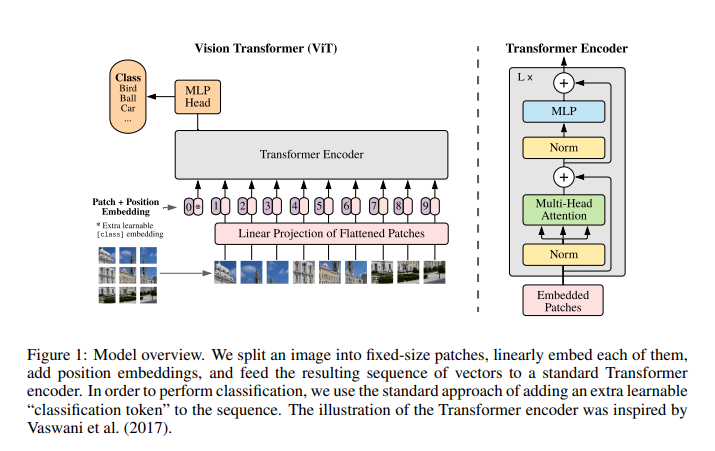

## 3. Method

### 3.1 Vision Transformer(ViT)



**RESHAPE**

ViT의 input은 2d image이기 때문에 reshape을 추가적으로 해주어야한다.

*   H x W x C 크기의 이미지 x를  N x ( P^2 * C) 크기의 flattened 2D patches x_p로 reshape 해준다. 
    * (H, W): 원본 이미지의 해상도
    * C: 채널 개수
    * (P, P): 각 image patch의 해상도
    * N: reshape 결과 나오게 되는 image patches의 개수

> 길이 N의, P^2 * C 차원 latent vector를 갖는 효율적인 input sequence(tokens)를 형성할 수 있다. 



**PROJECTION**

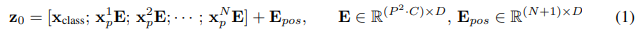

standard transformation에서는 input sequence(그리고 트랜스포머 내에 계속해 전달되는 query)들은 D차원의 latent vector를 가진다. 

* P^2 * C 차원의 image patch를 D차원으로 mapping시키는 linear projection을 한다. 
> 이 때 ouput을 patch embeddings라고 한다. 

**CLASS EMBEDDINGS**

* embedded patches의 좌측에 BERT와 유사하게 학습할 수 있는 [class] embedding, $z^{0}_{0} =  x_{class}$를 추가한다.
* 이 임베딩은 트랜스포머 인코더의 아웃풋 $z^{0}_{L}$(최종 L번째 Layer의 0번째 token)
 에서 결국 이미지 label $y$를 반환하는 역할을 한다.(예측이니 $\hat{y}$)


**Classification Head** 
* pre-training과 fine-tuning을 수행하는 동안에는 classification head가  $z^{0}_{L}$에 추가된다.
    * pre-training: MLP with 1- hidden layer 
    * fine-tuning: MLP with no hidden layer(only 1- linear layer)

**POSITIONAL EMBEDDINGS**
* patch embedding의 position정보를 유지하기 위해 standard learnable 1D position 사용. (2D-aware position embeddings을 사용했을 떄 성능 향상을 보이지 않았음)



**MULTI-HEAD ATTENTION**
* embedding sequence는 multi-head로 구성되고 self-attention 매커니즘이 적용된 encoder의 input으로 들어간다.

**Inductive bias**

Vision Transformer has much less image-specific inductive bias than
CNNs. 

In CNNs, locality, two-dimensional neighborhood structure, and translation equivariance are baked into each layer throughout the whole model. 

In ViT, only MLP layers are local and translationally equivariant, while the self-attention layers are global. The two-dimensional neighborhood
structure is used very sparingly: in the beginning of the model by cutting the image into patches and at fine-tuning time for adjusting the position embeddings for images of different resolution (as described below). Other than that, the position embeddings at initialization time carry no information
about the 2D positions of the patches and all spatial relations between the patches have to be learned from scratch.
 
  * translation equivariance: 
    
    equivariance란 쉽게 말하면 함수의 입력이 바뀌면 출력 또한 바뀐다는 뜻이고 translation equivariance는 입력의 위치가 변하면 출력도 동일하게 위치가 변한채로 나온다는 뜻이다.
    그래서 convolution연산을 하면 translation equivariance 특성과 더불어 파라미터를 공유하기때문에 필터 하나로 다양한 위치에서 특징들을 추출할 수 있다. 

    출처: 
    * [CNN과 이미지가 찰떡궁합인 이유](https://seoilgun.medium.com/cnn%EC%9D%98-stationarity%EC%99%80-locality-610166700979)
  
    참고: 
    * [CNN의 stationarity와 locality](https://seongkyun.github.io/study/2019/10/27/cnn_stationarity/)
    * [Translational Invariance Vs Translational Equivariance](https://towardsdatascience.com/translational-invariance-vs-translational-equivariance-f9fbc8fca63a)
    * [Translational Invariance Vs Translational Equivariance(한국어로 정리)](https://aibroker.tistory.com/entry/Paper-Reading2-Transforming-Auto-Encoder-Background-Translation-Equivariance-vs-Invariance)






**Hybrid Architecture** 

As an alternative to raw image patches, the input sequence can be formed
from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding
projection E (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case,
the patches can have spatial size 1x1, which means that the input sequence is obtained by simply
flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.
The classification input embedding and position embeddings are added as described above.

### 3.2 Fine-Tuning and Higher Resolution

ViT를 large dataset에 pre-train한 다음, down stream tasks에 fine-tuning을 진행한다. 이를 위해 pre-trained prediction head를 없애고, zero-initialized D × K의 feed forward layer를 attach한다. 이 때 K는 downstream task의 class 개수이다.

pre-training 때보다 더 높은 해상도로 fine-tune하는 것이 더 효과적이다. 

고해상도 이미지를 사용할 때에는, patch size를 동일하게 유지하여 더 길고 효과적인 sequence length를 사용한다.

pre-training 된 position embeddings는 더이상 의미가 없어지기 때문에, 원본 이미지에서의 location에 따라  pre-trained position embeddings에 2D interpolation을 수행한다.
> 이미지의 2D structure에 대한 inductive bias가 ViT에 수동으로 주입되는 부분은 이 resolution adjustment와 patch extraction 과정이 유일하다.
